# Tutorial: Generate features
This tutorial demonstrates how to generate features to represent game states to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.

This tutorial demonstrates the following three steps:
   1. Investigate the data in SPADL representation.
   2. Construct features to represent actions.
   3. Construct features to represent game states.

This notebook is compatible with `socceraction` version `0.2.0`.

**Conventions:**
   * Variables that refer a `DataFrame` object are prefixed with `df_`.
   * Variables that refer a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.
   
**References:**
   * Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
   * Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. \"[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)\" *Scientific Data 6*, no. 1 (2019): 1-15."

**Optional:** If you run this notebook on Google Colab, then uncomment the code in the following cell and execute the cell.

In [1]:
# !pip install tables==3.6.1
# !pip install matplotsoccer
# !pip install matplotlib

**Optional:** If you run this notebook on Google Colab and wish to store all data in a Google Drive folder, then uncomment the code in the following cell and execute the cell.

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %mkdir -p '/content/gdrive/My Drive/Friends of Tracking/'
# %cd '/content/gdrive/My Drive/Friends of Tracking/'

In [3]:
import warnings

import matplotsoccer
import numpy as np
import pandas as pd
from ipywidgets import fixed, interact_manual, widgets
from tqdm.notebook import tqdm

In [4]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Load dataset

First we load the SPADL dataset that was created in the tutorial1-run-pipeline.ipynb notebook. We first load the teams, players and games dataframes.

In [5]:
df_teams = pd.read_hdf('spadl.h5', key='teams')
df_players = pd.read_hdf('spadl.h5', key='players')
df_games = pd.read_hdf('spadl.h5', key='games')

We add the team names to the df_games dataframe such that we know which two teams played in which match.

In [6]:
# First, check what columns are available in df_teams
print("df_teams columns:", df_teams.columns.tolist())
print("df_games columns:", df_games.columns.tolist())

# Determine the correct column names for team ID and team name
team_id_col = 'wyId' if 'wyId' in df_teams.columns else ('team_id' if 'team_id' in df_teams.columns else None)
team_name_col = 'name' if 'name' in df_teams.columns else ('team_name' if 'team_name' in df_teams.columns else None)

if team_id_col and team_name_col:
    team_name_mapping = df_teams.set_index(team_id_col)[team_name_col].to_dict()
    
    # Extract away team ID from teamsData if it exists
    if 'teamsData' in df_games.columns:
        try:
            df_games['away_team_id'] = df_games['teamsData'].apply(
                lambda x: x.get('away', {}).get('wyId') if isinstance(x, dict) else None
            )
        except:
            df_games['away_team_id'] = None
    
    # Map team names
    df_games['home_team_name'] = df_games['home_team_id'].map(team_name_mapping).fillna('Unknown')
    df_games['away_team_name'] = df_games['away_team_id'].map(team_name_mapping).fillna('Unknown')
    print("Team names added successfully")
else:
    print(f"Warning: Could not find team ID column ({team_id_col}) or team name column ({team_name_col})")
    df_games['home_team_name'] = 'Unknown'
    df_games['away_team_name'] = 'Unknown'

df_teams columns: ['city', 'name', 'wyId', 'officialName', 'area', 'type']
df_games columns: ['status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc', 'winner', 'venue', 'wyId', 'label', 'date', 'referees', 'duration', 'competitionId', 'groupName', 'game_id', 'home_team_id']
Team names added successfully


# Explore SPADL actions

In this secion we will explore the SPADL actions for a selected match. In this notebook we chose the World Cup 2018 match between Belgium and Japan. The notebook can also be run for a match of your choice.

In [7]:
df_games

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName,game_id,home_team_id,away_team_id,home_team_name,away_team_name
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795,NaN,2565922,0,None,Unknown,Unknown
1,Played,4406122,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",181144,2018-05-20 16:30:00,0,Estadio Wanda Metropolitano,2565925,"Atlético Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",Regular,795,NaN,2565925,0,None,Unknown,Unknown
2,Played,4406122,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",181144,2018-05-20 14:15:00,691,San Mamés Barria,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 384957, 'role': 'referee'}, {'r...",Regular,795,NaN,2565919,0,None,Unknown,Unknown
3,Played,4406122,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",181144,2018-05-20 10:00:00,674,Estadio de Mestalla,2565924,"Valencia - Deportivo La Coruña, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2","[{'refereeId': 398913, 'role': 'referee'}, {'r...",Regular,795,NaN,2565924,0,None,Unknown,Unknown
4,Played,4406122,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2018-05-19 18:45:00,0,Estadio de la Cerámica,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795,NaN,2565927,0,None,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Played,4165363,1,"{'8493': {'scoreET': 0, 'coachId': 134090, 'si...",10078,2018-06-16 10:00:00,4418,Kazan' Arena,2057966,"France - Australia, 2 - 1",2018-06-16 12:00:00-02:00,"[{'refereeId': 378232, 'role': 'referee'}, {'r...",Regular,28,Group C,2057966,0,None,Unknown,Unknown
60,Played,4165363,1,"{'9905': {'scoreET': 0, 'coachId': 137521, 'si...",10078,2018-06-15 18:00:00,0,Olimpiyskiy Stadion Fisht,2057960,"Portugal - Spain, 3 - 3",2018-06-15 20:00:00-02:00,"[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,28,Group B,2057960,0,None,Unknown,Unknown
61,Played,4165363,1,"{'10840': {'scoreET': 0, 'coachId': 136612, 's...",10078,2018-06-15 15:00:00,10840,Stadion Krestovskyi,2057961,"Morocco - Iran, 0 - 1",2018-06-15 17:00:00-02:00,"[{'refereeId': 384995, 'role': 'referee'}, {'r...",Regular,28,Group B,2057961,0,None,Unknown,Unknown
62,Played,4165363,1,"{'16129': {'scoreET': 0, 'coachId': 33204, 'si...",10078,2018-06-15 12:00:00,15670,Stadion Central'nyj,2057955,"Egypt - Uruguay, 0 - 1",2018-06-15 14:00:00-02:00,"[{'refereeId': 377215, 'role': 'referee'}, {'r...",Regular,28,Group A,2057955,0,None,Unknown,Unknown


In [8]:
df_games[(df_games['home_team_name'] == 'Belgium') & 
         (df_games['away_team_name'] == 'Japan')]

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName,game_id,home_team_id,away_team_id,home_team_name,away_team_name


**Note:** This notebook expects the data for the World Cup 2018 to be in the SPADL dataset. Make sure that the `game_id` selected in the cell below belongs to a game in your dataset.

In [9]:
# Check what's actually in the HDF5 file
with pd.HDFStore('spadl.h5') as store:
    keys = store.keys()
    print(f"All keys in spadl.h5:")
    for key in keys:
        print(f"  {key}")
    print(f"\nFile info:")
    store.info()

All keys in spadl.h5:
  /actiontypes
  /bodyparts
  /games
  /players
  /results
  /teams
  /actions/game_1694390
  /actions/game_1694391
  /actions/game_1694392
  /actions/game_1694393
  /actions/game_1694394
  /actions/game_1694395
  /actions/game_1694396
  /actions/game_1694397
  /actions/game_1694398
  /actions/game_1694399
  /actions/game_1694400
  /actions/game_1694401
  /actions/game_1694402
  /actions/game_1694403
  /actions/game_1694404
  /actions/game_1694405
  /actions/game_1694406
  /actions/game_1694407
  /actions/game_1694408
  /actions/game_1694409
  /actions/game_1694410
  /actions/game_1694411
  /actions/game_1694412
  /actions/game_1694413
  /actions/game_1694414
  /actions/game_1694415
  /actions/game_1694416
  /actions/game_1694417
  /actions/game_1694418
  /actions/game_1694419
  /actions/game_1694420
  /actions/game_1694421
  /actions/game_1694422
  /actions/game_1694423
  /actions/game_1694424
  /actions/game_1694425
  /actions/game_1694426
  /actions/game_169442

In [10]:
# Check raw event data structure to understand location format
with pd.HDFStore('spadl.h5') as store:
    # Get some raw event data to inspect
    print("Sample raw events to check location format:")
    # Try to read events from any available source
    # For now, let's just show what columns we have
    
# Since we don't have direct access to raw events in tutorial2, let's inspect the actions we have
with pd.HDFStore('spadl.h5') as store:
    sample_actions = store['actions/game_1694390'].head(10)
    print("\nCurrent action coordinates (all show default 50, 34):")
    print(sample_actions[['start_x', 'start_y', 'end_x', 'end_y']])
    print("\nThis shows the issue - we need to fix location extraction in tutorial1")

Sample raw events to check location format:

Current action coordinates (all show default 50, 34):
   start_x  start_y  end_x  end_y
0       50       48     47     50
1       47       50     41     48
2       41       48     32     35
3       32       35     89      6
4       89        6     85      0
5       11       94     15    100
6       85        0     93     16
7        7       84      9     71
8       91       29      0      0
9      100      100     15    100

This shows the issue - we need to fix location extraction in tutorial1


## Load SPADL actions for selected game

For each action, the dataset contains the following information for the action:

* game_id: a unique identifier of the game;
* team_id: a unique identifier of the team who performed the action;
* player_id: a unique identifier of the player who performed the action;
* period: 1 for the first half and 2 for the second half;
* seconds: the time elapsed in seconds since the start of the half;
* type_id: the identifier for the type of action;
* type_name: the name for the type of action;
* body_part_id: 0 for foot, 1 for head, 2 for other body part;
* result: the result of the action: 0 for failure, 1 for success;
* start_x: the x coordinate for the location where the action started, ranges from 0 to 105;
* start_y: the y coordinate for the location where the action started, ranges from 0 to 68;
* end_x: the x coordinate for the location where the action ended, ranges from 0 to 105;
* end_y: the y coordinate for the location where the action ended, ranges from 0 to 68.

The action types are:

    0: pass
    1: cross
    2: throw in
    3: freekick crossed
    4: freekick short
    5: corner crossed
    6: corner short
    7: take on
    8: foul
    9: tackle
    10: interception
    11: shot
    12: shot penalty
    13: shot freekick
    14: keeper save
    18: clearance
    21: dribble
    22: goalkick

We first load the actions for the selected game_id.

In [11]:
with pd.HDFStore('spadl.h5') as spadlstore:
    # Check if actions data exists
    available_keys = spadlstore.keys()
    action_keys = [k for k in available_keys if 'actions/game' in k]
    
    if not action_keys:
        print("ERROR: No action data found in spadl.h5!")
        print("You need to run tutorial1-run-pipeline.ipynb to completion first.")
        print(f"Available keys: {available_keys}")
    else:
        # Get the first available game with actions
        game_id = int(action_keys[0].split('_')[-1])
        print(f"Loading actions for game_id = {game_id}")
        
        df_actions = spadlstore[f'actions/game_{game_id}']
        
        # Merge with reference tables using proper column names
        df_actiontypes = spadlstore['actiontypes']
        df_bodyparts = spadlstore['bodyparts']
        df_results = spadlstore['results']
        
        # Merge with type_id
        df_actions = df_actions.merge(df_actiontypes, left_on='type_id', right_on='type_id', how='left')
        
        # Merge with body_part_id
        df_actions = df_actions.merge(df_bodyparts, left_on='body_part_id', right_on='bodypart_id', how='left')
        
        # Merge with result_id  
        df_actions = df_actions.merge(df_results, left_on='result_id', right_on='result_id', how='left')
        
        # Try to merge with players (may not exist, so use left merge)
        try:
            df_players_ref = spadlstore['players']
            df_actions = df_actions.merge(df_players_ref, left_on='player_id', right_on='player_id', how='left', suffixes=('', '_player'))
        except:
            print("Note: Players reference not available")
        
        # Try to merge with teams (may not exist, so use left merge)
        try:
            df_teams_ref = spadlstore['teams']
            df_actions = df_actions.merge(df_teams_ref, left_on='team_id', right_on='team_id', how='left', suffixes=('', '_team'))
        except:
            print("Note: Teams reference not available")
        
        df_actions = df_actions.reset_index().rename(columns={'index': 'action_id'})
        
        print(f"Loaded {len(df_actions)} actions for game {game_id}")


Loading actions for game_id = 1694390
Note: Players reference not available
Note: Teams reference not available
Loaded 1641 actions for game 1694390


In [14]:
# Look at first 5 actions of the match
df_actions[:5]

,action_id,game_id,team_id,player_id,period_id,time_seconds,type_id,body_part_id,result_id,start_x,start_y,end_x,end_y,type_name,bodypart_id,bodypart_name,result_name
0,0,1694390,4418,26010,1,1.255990,0,0,0,50,48,47,50,pass,0,foot,unsuccessful
1,1,1694390,4418,3682,1,2.351908,0,0,0,47,50,41,48,pass,0,foot,unsuccessful
2,2,1694390,4418,31528,1,3.241028,0,0,0,41,48,32,35,pass,0,foot,unsuccessful
3,3,1694390,4418,7855,1,6.033681,0,0,0,32,35,89,6,pass,0,foot,unsuccessful
4,4,1694390,4418,25437,1,13.143591,0,0,0,89,6,85,0,pass,0,foot,unsuccessful


The following cells define some functions to make it more convenient to explore the actions.

In [13]:
def nice_time(row):
    minute = int((row['period_id']>=2) * 45 + (row['period_id']>=3) * 15 + 
                 (row['period_id']==4) * 15 + row['time_seconds'] // 60)
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

df_actions['nice_time'] = df_actions.apply(nice_time,axis=1)

In [14]:
def action_name(row):
    # Use short_name if available, otherwise use player_id
    player_info = row['short_name'] if 'short_name' in row.index else f"P{row['player_id']}"
    return f"{row['action_id']}: {row['nice_time']} - {player_info} {row['type_name']}"

df_actions['action_name'] = df_actions.apply(action_name, axis=1)

In [15]:
def plot_actions(df_actions_to_plot):
    # Create team_name column if it doesn't exist
    if 'team_name' not in df_actions_to_plot.columns:
        df_actions_to_plot = df_actions_to_plot.copy()
        df_actions_to_plot['team_name'] = df_actions_to_plot['team_id'].astype(str)
    
    # Create short_name column if it doesn't exist
    if 'short_name' not in df_actions_to_plot.columns:
        df_actions_to_plot = df_actions_to_plot.copy()
        df_actions_to_plot['short_name'] = 'P' + df_actions_to_plot['player_id'].astype(str)
    
    # Create short_team_name column if it doesn't exist
    if 'short_team_name' not in df_actions_to_plot.columns:
        df_actions_to_plot = df_actions_to_plot.copy()
        df_actions_to_plot['short_team_name'] = df_actions_to_plot['team_id'].astype(str)
    
    try:
        matplotsoccer.actions(
            location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
            action_type=df_actions_to_plot['type_name'],
            team=df_actions_to_plot['team_name'],
            result=df_actions_to_plot['result_name'] == 'success',
            label=df_actions_to_plot[['nice_time', 'type_name', 'short_name', 'short_team_name']],
            labeltitle=['time', 'actiontype', 'player', 'team'],
            zoom=False,
            figsize=8)
    except AttributeError as e:
        if 'np.NaN' in str(e):
            print("Note: matplotsoccer has a NumPy 2.0 compatibility issue. Plot skipped.")
            print("The data is ready for feature generation - you can proceed with the pipeline.")
        else:
            raise

In [16]:
def plot_actions_from_action_name(df_actions, action_name):
    action_id = int(action_name.split(':')[0])
    df_actions_to_plot = df_actions[action_id-3: action_id+3]
    plot_actions(df_actions_to_plot)

The following cell shows a widget which we can use to easily explore the actions in our dataset.

In [17]:
interact_manual(plot_actions_from_action_name, 
                df_actions = fixed(df_actions),
                action_name=widgets.Select(
                    options = df_actions['action_name'][3:],
                    disabled=False)
               )


interactive(children=(Select(description='action_name', options=('3: 0m6s - P7855 pass', '4: 0m13s - P25437 pa…

<function __main__.plot_actions_from_action_name(df_actions, action_name)>

# Representing actions

In this section we will create features that describe the action. We will take one action as an example. Every action has several characteristics, these include: 
* start location
* end location
* action type
* bodypart used
* result (successful or not)
* time in the match

Note: matplotsoccer has a NumPy 2.0 compatibility issue. Plot skipped.
The data is ready for feature generation - you can proceed with the pipeline.


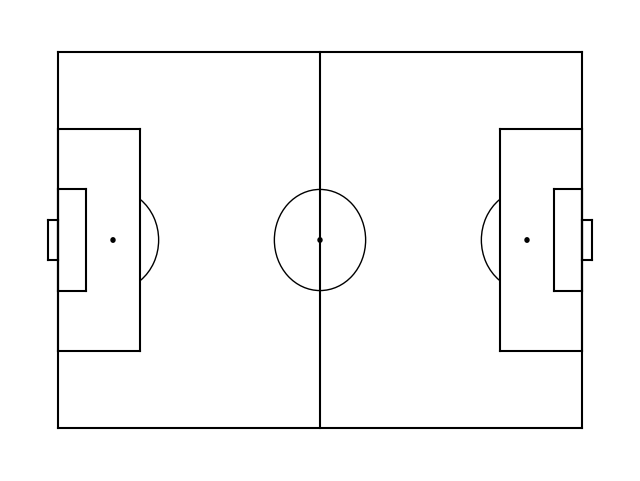

In [18]:
action_id = 145
plot_actions(df_actions[action_id:action_id+1])

In [19]:
df_actions[action_id:action_id+1].T

,145
action_id,145
game_id,1694390
team_id,11944
player_id,33235
period_id,1
time_seconds,512.014326
type_id,0
body_part_id,0
result_id,0
start_x,69


## Representing locations

We will first take a look at how we can represent locations. We first define the pitch sizes as used in the SPADL representation. A very interesting blog post by the KU Leuven on the interplay between features and models in football can be found here: https://dtai.cs.kuleuven.be/sports/blog/illustrating-the-interplay-between-features-and-models-in-xg.

In [34]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

In [21]:
df_actions[action_id:action_id+1][['start_x', 'start_y', 'end_x', 'end_y']]

,start_x,start_y,end_x,end_y
145,69,25,63,40


The following cell adds columns to the actions dataframe with the normalized start and end coordinates of the actions.

In [22]:
for side in ['start', 'end']:
    # Normalize the X location
    key_x = f'{side}_x'
    df_actions[f'{key_x}_norm'] = df_actions[key_x] / PITCH_LENGTH

    # Normalize the Y location
    key_y = f'{side}_y'
    df_actions[f'{key_y}_norm'] = df_actions[key_y] / PITCH_WIDTH

In [23]:
df_actions[action_id:action_id+1][['start_x_norm', 'start_y_norm', 'end_x_norm', 'end_y_norm']]

,start_x_norm,start_y_norm,end_x_norm,end_y_norm
145,0.657143,0.367647,0.6,0.588235


The following cells compute the polar coordinates of the start and end location of the actions.

In [35]:
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

In [25]:
for side in ['start', 'end']:
    diff_x = GOAL_X - df_actions[f'{side}_x']
    diff_y = abs(GOAL_Y - df_actions[f'{side}_y'])
    df_actions[f'{side}_distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    df_actions[f'{side}_angle_to_goal'] = np.divide(diff_x, diff_y, 
                                                    out=np.zeros_like(diff_x), 
                                                    where=(diff_y != 0))

c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [26]:
df_actions[action_id:action_id+1][['start_distance_to_goal', 'start_angle_to_goal', 'end_distance_to_goal', 'end_angle_to_goal']]

,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal
145,37.107951,4,42.426407,7


The following cell adds a column indicating whether the action starts and/or ends in the opponent penalty box. 

*Exercise*: think of more features describing the start and end location of the action.

In [27]:
for side in ['start', 'end']:
    df_actions[f'{side}_is_penalty_box'] = ((df_actions[f'{side}_x'] > (PITCH_LENGTH-16.5)) & 
                                            (df_actions[f'{side}_y'] > (13.85)) & 
                                            (df_actions[f'{side}_y'] > (PITCH_WIDTH-13.85)))

In [28]:
df_actions[action_id:action_id+1][['start_is_penalty_box', 'end_is_penalty_box']]

,start_is_penalty_box,end_is_penalty_box
145,False,False


## Representing body part, action type and result

The following cells inspect the type_name, bodypart_name and result_name columns.

In [29]:
pd.get_dummies(df_actions['type_name'])

,pass
0,True
1,True
2,True
3,True
4,True
...,...
1636,True
1637,True
1638,True
1639,True


In [26]:
def add_action_type_dummies(df_actions):
    return df_actions.merge(pd.get_dummies(df_actions['type_name']), how='left',
                             left_index=True, right_index=True)

In [31]:
df_actions = add_action_type_dummies(df_actions)

In [32]:
df_actions[action_id:action_id+1]

,action_id,game_id,team_id,player_id,period_id,time_seconds,type_id,body_part_id,result_id,start_x,...,start_y_norm,end_x_norm,end_y_norm,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal,start_is_penalty_box,end_is_penalty_box,pass
145,145,1694390,11944,33235,1,512.014326,0,0,0,69,...,0.367647,0.6,0.588235,37.107951,4,42.426407,7,False,False,True


In [33]:
df_actions['bodypart_name'].unique()

<StringArray>
['foot']
Length: 1, dtype: str

In [34]:
df_actions['result_name'].unique()

<StringArray>
['unsuccessful']
Length: 1, dtype: str

In [35]:
df_actions[action_id:action_id+1][['bodypart_name', 'result_name']]

,bodypart_name,result_name
145,foot,unsuccessful


## Determine distance covered in x, y and total time played

The following cells define functions that add distance features and the actual time played in the match at the moment of the action.

In [36]:
def add_distance_features(df_actions):
    df_actions['diff_x'] = df_actions['end_x'] - df_actions['start_x']
    df_actions['diff_y'] = df_actions['end_y'] - df_actions['start_y']
    df_actions['distance_covered'] = np.sqrt((df_actions['end_x'] - df_actions['start_x']) ** 2 +
                                             (df_actions['end_y'] - df_actions['start_y']) ** 2)

In [27]:
def add_time_played(df_actions):
    df_actions['time_played'] = (df_actions['time_seconds'] + 
                             (df_actions['period_id'] >= 2) * (45 * 60) + 
                             (df_actions['period_id'] >= 3) * (15 * 60) + 
                             (df_actions['period_id'] == 4) * (15 * 60)
                             )

In [38]:
add_distance_features(df_actions)
add_time_played(df_actions)

In [39]:
df_actions[action_id:action_id+1][['diff_x', 'diff_y', 'distance_covered', 'time_played']]

,diff_x,diff_y,distance_covered,time_played
145,-6,15,16.155494,512.014326


# Representing game states

As a game state is more than just the previous action, we want to add more information on the sequence leading up to the action. This includes information on the previous actions, but also more contextual features like the score and time in the match.

## Representing actions leading to game state

In the \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" paper we take the three actions leading to the game state into account. We investigated how many actions we should include and got the best results for three actions back. 

*Exercise:* you could try out different numbers of actions to include in the game state and analyze the results.

Let's first take a look at the action again and what happened before the action was executed.

Note: matplotsoccer has a NumPy 2.0 compatibility issue. Plot skipped.
The data is ready for feature generation - you can proceed with the pipeline.
Note: matplotsoccer has a NumPy 2.0 compatibility issue. Plot skipped.
The data is ready for feature generation - you can proceed with the pipeline.
Note: matplotsoccer has a NumPy 2.0 compatibility issue. Plot skipped.
The data is ready for feature generation - you can proceed with the pipeline.


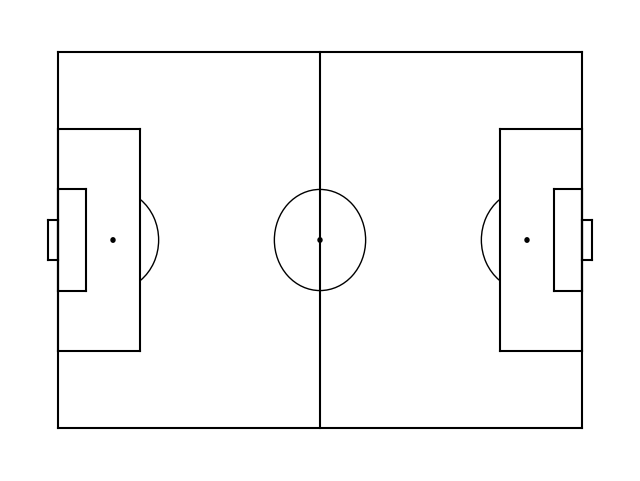

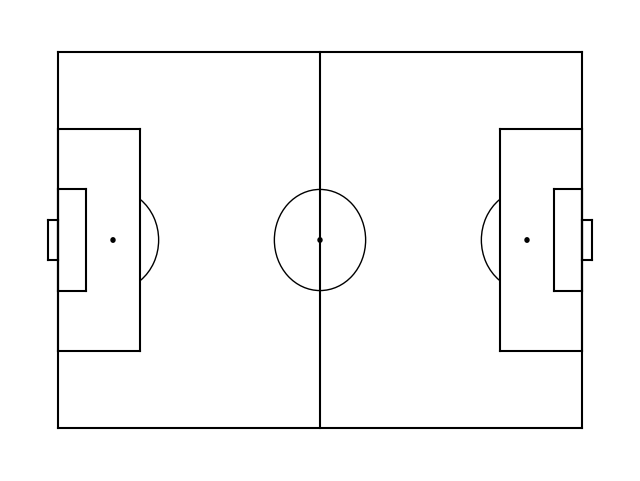

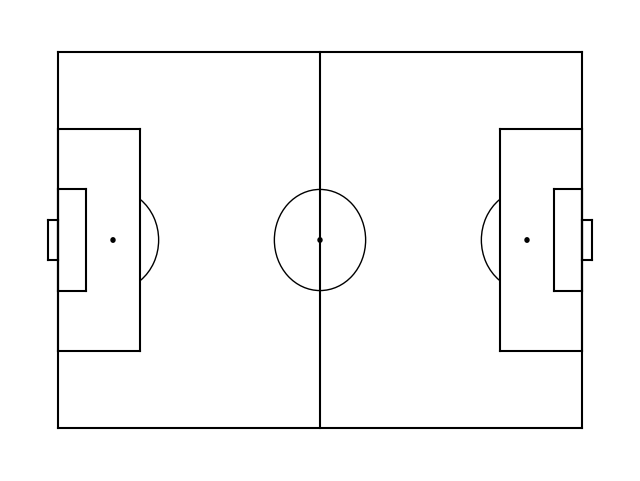

In [40]:
for i in range(3):
    df_actions_to_plot = df_actions[145-i:146]
    plot_actions(df_actions_to_plot)

The following cells add extra columns for each action on the x actions before the action itself. You can define how far back you want to go and what features to take into account for all actions.

In [25]:
delays = 3  # you can play around with this number
features_to_delay = ['game_id', 'period_id', 'time_seconds', 'team_id',
                     'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                     'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                     'time_played']

In [28]:
def create_delayed_features(df_actions, features_to_delay, delays):
    df_delays = [df_actions[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0, delays)]
    return pd.concat(df_delays, axis=1)

In [43]:
df_features = create_delayed_features(df_actions, features_to_delay, delays)

In [44]:
location_cols = [f'{side}_{xy}-{delay}' for delay in reversed(range(0, delays))
                 for xy in ['x', 'y'] for side in ['start', 'end']]
df_features[action_id:action_id+1][location_cols]

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0
145,42.0,57.0,90.0,98.0,57.0,69.0,98.0,25.0,69,63,25,40


In [45]:
cols = [f'{col}-{delay}' for delay in reversed(range(0, delays))
        for col in ['period_id', 'time_seconds', 'type_name', 'bodypart_name', 'result_name']]
df_features[action_id:action_id+1][cols]

,period_id-2,time_seconds-2,type_name-2,bodypart_name-2,result_name-2,period_id-1,time_seconds-1,type_name-1,bodypart_name-1,result_name-1,period_id-0,time_seconds-0,type_name-0,bodypart_name-0,result_name-0
145,1.0,504.166369,pass,foot,unsuccessful,1.0,507.046369,pass,foot,unsuccessful,1,512.014326,pass,foot,unsuccessful


We need to invert the coordinates for the actions made by the other team to make sure all features represent the same thing. Therefore we add an indicator for the delayed actions to indicate whether the action was executed by the same team or not. If not then we need to invert the coordinates as the coordinates normally always go from left to right for the team in possession.

In [29]:
def add_same_team(df_features, delays):
    for step in range(1, delays):
        df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

In [47]:
add_same_team(df_features, delays)

In [30]:
def invert_coordinates(df_features, delays):
    for step in range(1, delays):
        for side in ['start', 'end']:
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_x-{step}'] = PITCH_LENGTH - df_features[f'{side}_x-{step}']
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_y-{step}'] = PITCH_WIDTH - df_features[f'{side}_y-{step}']

In [49]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1631,74.0,76.0,19.0,45.0,76.0,70.0,45.0,52.0,30,31,48,26,False,False
1632,76.0,70.0,45.0,52.0,30.0,31.0,48.0,26.0,70,69,52,74,False,True
1633,30.0,31.0,48.0,26.0,70.0,69.0,52.0,74.0,69,74,74,88,True,False
1634,70.0,69.0,52.0,74.0,69.0,74.0,74.0,88.0,74,73,88,76,True,True
1635,69.0,74.0,74.0,88.0,74.0,73.0,88.0,76.0,73,65,76,54,True,True
1636,74.0,73.0,88.0,76.0,73.0,65.0,76.0,54.0,65,55,54,61,True,True
1637,73.0,65.0,76.0,54.0,65.0,55.0,54.0,61.0,55,40,61,76,True,True
1638,65.0,55.0,54.0,61.0,55.0,40.0,61.0,76.0,40,52,76,90,True,True
1639,55.0,40.0,61.0,76.0,40.0,52.0,76.0,90.0,52,63,90,78,True,True
1640,40.0,52.0,76.0,90.0,52.0,63.0,90.0,78.0,63,0,78,0,True,True


In [50]:
invert_coordinates(df_features, delays)

In [51]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1631,31.0,29.0,49.0,23.0,29.0,35.0,23.0,16.0,30,31,48,26,False,False
1632,76.0,70.0,45.0,52.0,75.0,74.0,20.0,42.0,70,69,52,74,False,True
1633,75.0,74.0,20.0,42.0,70.0,69.0,52.0,74.0,69,74,74,88,True,False
1634,70.0,69.0,52.0,74.0,69.0,74.0,74.0,88.0,74,73,88,76,True,True
1635,69.0,74.0,74.0,88.0,74.0,73.0,88.0,76.0,73,65,76,54,True,True
1636,74.0,73.0,88.0,76.0,73.0,65.0,76.0,54.0,65,55,54,61,True,True
1637,73.0,65.0,76.0,54.0,65.0,55.0,54.0,61.0,55,40,61,76,True,True
1638,65.0,55.0,54.0,61.0,55.0,40.0,61.0,76.0,40,52,76,90,True,True
1639,55.0,40.0,61.0,76.0,40.0,52.0,76.0,90.0,52,63,90,78,True,True
1640,40.0,52.0,76.0,90.0,52.0,63.0,90.0,78.0,63,0,78,0,True,True


The following cells add the location featues for all actions and their delayed actions using the right coordinates.

In [31]:
def add_location_features(df_features, delays):
    for step in range(0, delays):
        for side in ['start', 'end']:
            # Normalize the X location
            key_x = f'{side}_x'
            df_features[f'{key_x}_norm-{step}'] = df_features[f'{key_x}-{step}'] / PITCH_LENGTH

            # Normalize the Y location
            key_y = f'{side}_y'
            df_features[f'{key_y}_norm-{step}'] = df_features[f'{key_y}-{step}'] / PITCH_WIDTH

            diff_x = GOAL_X - df_features[f'{side}_x-{step}']
            diff_y = abs(GOAL_Y - df_features[f'{side}_y-{step}'])
            df_features[f'{side}_distance_to_goal-{step}'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
            df_features[f'{side}_angle_to_goal-{step}'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))

            df_features[f'diff_x-{step}'] = df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']
            df_features[f'diff_y-{step}'] = df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']
            df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']) ** 2 +
                                             (df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']) ** 2)

In [53]:
add_location_features(df_features, delays)

c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [54]:
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,start_y_norm-2,start_distance_to_goal-2,start_angle_to_goal-2,diff_x-2,diff_y-2,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2
0,1694390,1,1.255990,4418,26010,50,48,47,50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1694390,1,2.351908,4418,3682,47,50,41,48,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1694390,1,3.241028,4418,31528,41,48,32,35,0,...,0.705882,56.753854,3.928571,-3.0,2.0,3.605551,0.447619,0.735294,60.166436,3.625000
3,1694390,1,6.033681,4418,7855,32,35,89,6,0,...,0.735294,60.166436,3.625000,-6.0,-2.0,6.324555,0.390476,0.705882,65.513357,4.571429
4,1694390,1,13.143591,4418,25437,89,6,85,0,0,...,0.705882,65.513357,4.571429,-9.0,-13.0,15.811388,0.304762,0.514706,73.006849,73.000000


## Adding contextual features

We also want to add some additional context to the game state. For example the speed of play, the time in the match and the current score in the match might influence the value of the game state.

*Exercise:* think of extra features that might influence the value of a game state.

## Sequence features

The following cells add extra context on the sequence. The distance covered in x and y direction as well as the time passed in the sequence are added to the dataframe. These features might tell the model something about the speed of play, whether the game quickly progressed from one side to another (probably indicating a counter attack) or whether it is a slow build up play. 

In [32]:
def add_sequence_pre_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_pre'] = df_features['start_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_pre'] = df_features['start_y-0'] - df_features[f'start_y-{delay}']
    df_features['time_sequence_pre'] = df_features['time_played-0'] - df_features[f'time_played-{delay}']

In [56]:
add_sequence_pre_features(df_features, delays)

In [33]:
def add_sequence_post_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_post'] = df_features['end_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_post'] = df_features['end_y-0'] - df_features[f'start_y-{delay}']

In [58]:
add_sequence_post_features(df_features, delays)

In [59]:
df_features[action_id:action_id+1]

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post
145,1694390,1,512.014326,11944,33235,69,25,63,40,0,...,17.0,0.542857,1.441176,80.0,0.75,27.0,-65.0,7.847957,21.0,-50.0


# Generate features for a match

The following cell defines a function that creates all features described above for a dataframe of actions for a given match.

In [23]:
def create_features_match(df_actions, features_to_delay, delays):
    df_action_features = add_action_type_dummies(df_actions)
    add_time_played(df_action_features)
    df_gamestate_features = create_delayed_features(df_action_features, features_to_delay, delays)
    add_same_team(df_gamestate_features, delays)
    invert_coordinates(df_gamestate_features, delays)
    add_location_features(df_gamestate_features, delays)
    add_sequence_pre_features(df_gamestate_features, delays)
    add_sequence_post_features(df_gamestate_features, delays)
    return df_gamestate_features

# Generate labels for a match

The following cells define two functions that compute the labels of our two machine learning tasks. The first one tells us whether a goal was scored within x actions, whereas the second function tells us whether a goal was conceded within the next x actions.

*Exercise*: play around with the number of actions to look ahead. In our paper we look 10 actions ahead.

In [36]:
def label_scores(df_actions, nr_actions):
    """
    This functiondf_actions determines whether a goal was scored by the team possessing 
    the ball within the next x actions
    """
    # merging goals, owngoals and team_ids

    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    scores = y['goal']
    for i in range(1, nr_actions):
        goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        own_goal_opponent = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        scores = scores | goal_scored | own_goal_opponent

    return pd.DataFrame(scores, columns=['scores'])

In [37]:
def label_concedes(df_actions, nr_actions):
    """
    This function determines whether a goal was scored by the team not 
    possessing the ball within the next x actions
    """
    # merging goals,owngoals and team_ids
    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']
    
    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    concedes = y['owngoal']
    for i in range(1, nr_actions):
        goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        own_goal_team = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        concedes = concedes | goal_opponent | own_goal_team

    return pd.DataFrame(concedes, columns=['concedes'])

We compute the labels for the match and investigate the labels for the last ten actions in the match.

In [12]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                           label_concedes(df_actions, nr_actions=10)], 
                          axis=1)

In [13]:
df_labels.tail(10)

,scores,concedes
1631,False,False
1632,False,False
1633,False,False
1634,False,False
1635,False,False
1636,False,False
1637,False,False
1638,False,False
1639,False,False
1640,False,False


In [15]:
pd.merge(df_actions[['team_id', 'player_id', 'type_name']], 
         df_labels, 
         left_index=True, 
         right_index=True).tail(10)

,team_id,player_id,type_name,scores,concedes
1631,11944,84536,pass,False,False
1632,4418,231139,pass,False,False
1633,4418,231139,pass,False,False
1634,4418,7858,pass,False,False
1635,4418,231139,pass,False,False
1636,4418,25804,pass,False,False
1637,4418,7915,pass,False,False
1638,4418,3276,pass,False,False
1639,4418,31528,pass,False,False
1640,4418,25804,pass,False,False


# Generate features and labels for all matches

The following cells generate and store the features and labels for all matches in your spadl.h5 file. This might take some minutes.

In [38]:
df_games = pd.read_hdf('spadl.h5', key='games')

In [20]:
df_games.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName,game_id,home_team_id
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795,NaN,2565922,0
1,Played,4406122,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",181144,2018-05-20 16:30:00,0,Estadio Wanda Metropolitano,2565925,"Atlético Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",Regular,795,NaN,2565925,0
2,Played,4406122,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",181144,2018-05-20 14:15:00,691,San Mamés Barria,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 384957, 'role': 'referee'}, {'r...",Regular,795,NaN,2565919,0
3,Played,4406122,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",181144,2018-05-20 10:00:00,674,Estadio de Mestalla,2565924,"Valencia - Deportivo La Coruña, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2","[{'refereeId': 398913, 'role': 'referee'}, {'r...",Regular,795,NaN,2565924,0
4,Played,4406122,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2018-05-19 18:45:00,0,Estadio de la Cerámica,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795,NaN,2565927,0


In [41]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], left_on='type_id', right_on='type_id', how='left')
            .merge(spadlstore['results'], left_on='result_id', right_on='result_id', how='left')
            .merge(spadlstore['bodyparts'], left_on='body_part_id', right_on='bodypart_id', how='left')
            .reset_index(drop=True)
        )
    
    df_features = create_features_match(df_actions, features_to_delay, delays)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    
    df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                           label_concedes(df_actions, nr_actions=10)], 
                          axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/495 [00:00<?, ?it/s]

c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valuing-actions\venv\Lib\site-packages\pandas\core\series.py:899: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\anma10\PycharmProjects\fot-valu